In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from MODULES.encoders_decoders import *
import torch

In [3]:
from MODULES.vae_model import *
from MODULES.utilities_ml import process_one_epoch
from MODULES.utilities_visualization import show_batch
import torch.nn.functional as F
from MODULES.utilities_ml import ConditionalRandomCrop, SpecialDataSet, process_one_epoch


# Check versions
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

python_version() --->  3.8.2
torch.__version__ -->  1.6.0


In [13]:
multi_mnist_data_train = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/dataset_multiMNIST/multi_mnist_train.pt"
multi_mnist_data_test = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/dataset_multiMNIST/multi_mnist_test.pt"

multi_mnist_data_train = "data_train.pt"
multi_mnist_data_test = "data_test.pt"


params = load_json_as_dict("./ML_parameters.json")
img_train, seg_mask_train, count_train  = load_obj(multi_mnist_data_train)
img_test, seg_mask_test, count_test  = load_obj(multi_mnist_data_test)

BATCH_SIZE = params["simulation"]["batch_size"]
SIZE_CROPS = params["input_image"]["size_raw_image"]
#N_TEST = params["simulation"]["N_test"]
#N_TRAIN = params["simulation"]["N_train"]

train_loader = SpecialDataSet(img=img_train, 
                              roi_mask=None, 
                              seg_mask=seg_mask_train, 
                              labels=count_train, 
                              batch_size=4, #BATCH_SIZE , 
                              drop_last=False,
                              shuffle=True)

test_loader = SpecialDataSet(img=img_test, 
                             roi_mask=None, 
                             seg_mask=seg_mask_test, 
                             labels=count_test, 
                             batch_size=4, #BATCH_SIZE , 
                             drop_last=False,
                             shuffle=False)

test_batch_example_fig = test_loader.check_batch()
train_batch_example_fig = train_loader.check_batch()

Dataset lenght: 200
img.shape torch.Size([200, 1, 80, 80])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes seg.shape labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.) tensor(0.9973)
Dataset lenght: 200
img.shape torch.Size([200, 1, 80, 80])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes seg.shape labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.) tensor(0.9973)


Dataset lenght: 200
img.shape torch.Size([200, 1, 80, 80])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes seg.shape labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.) tensor(0.9973)


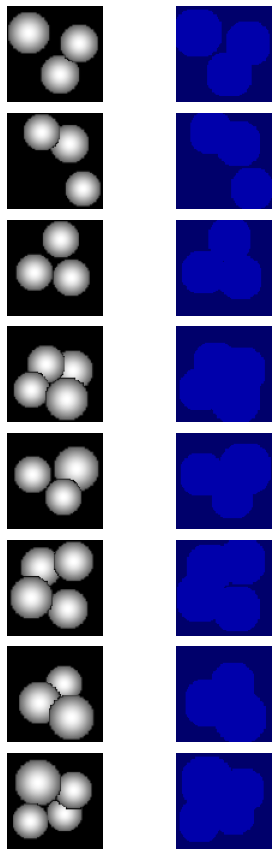

In [14]:
train_batch_example_fig = train_loader.check_batch()
train_batch_example_fig

Uninitialized: You must initialize neptune-client first. For more information, please visit: https://github.com/neptune-ai/neptune-client#initialize-neptune

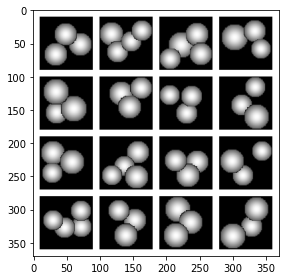

In [15]:

index_tmp = torch.arange(16)
reference_imgs, reference_seg, reference_count = test_loader.load(index=index_tmp)[:3]
reference_imgs_fig = show_batch(reference_imgs, normalize_range=(0.0, 1.0), neptune_name="reference_imgs")


In [16]:
params

{'neptune_project': 'dalessioluca/DISK',
 'simulation': {'__comment': 'there are 3 types of runs: scratch, resume, pretrained',
  'type': 'scratch',
  'MAX_EPOCHS': 501,
  'TEST_FREQUENCY': 50,
  'CHECKPOINT_FREQUENCY': 50,
  'batch_size': 8},
 'architecture': {'__comment': 'architecture parameters, level_zwhere_output is between 0 and n_max_pool included',
  'dim_zinstance': 20,
  'dim_zwhere': 4,
  'dim_zbg': 20,
  'dim_logit': 1,
  'cropped_size': 28,
  'n_max_pool': 4,
  'level_zwhere_and_logit_output': 2,
  'level_background_output': 4,
  'n_ch_after_first_two_conv': 32,
  'concatenate_raw_image_to_fmap': False,
  'crop_raw_image': True,
  'n_ch_output_features': 1},
 'DPP': {'__comment': 'parameters for the DPP prior', 'n_kernels': 1},
 'input_image': {'__comment': 'parameters describing the input images',
  'n_objects_max': 6,
  'size_object_min': 15,
  'size_object_max': 50,
  'length_scale_similarity': 10.0,
  'size_raw_image': 80,
  'ch_in': 1},
 'nms': {'__comment': 'paramet

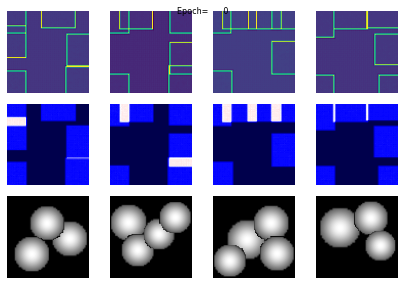

In [30]:
from MODULES.utilities_visualization import plot_overlap_and_fmaps
vae = CompositionalVae(params)
optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])

epoch_restart = -1
history_dict = {}
min_test_loss = 999999
epoch=0

output: Output = vae.forward(reference_imgs,
                             overlap_threshold=params["nms"]["overlap_threshold_train"],
                             noisy_sampling=True,
                             draw_image=True,
                             draw_boxes=True,
                             draw_bg=True,
                             verbose=False)
    
fig_fmap = plot_overlap_and_fmaps(output, epoch=epoch)
fig_fmap



             

In [31]:
tmp = output.inference.big_mask_times_c.sum(dim=-5)
torch.max(tmp[0])

tensor(1.0499, grad_fn=<MaxBackward1>)

In [23]:
vae = CompositionalVae(params)
vae.prob_corr_factor = 0.5
optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])

In [24]:
for epoch in range(1):
    train_metrics = process_one_epoch(model=vae, 
                                      dataloader=test_loader, 
                                      optimizer=optimizer, 
                                      verbose=(epoch == 0),
                                      weight_clipper=None)

i =   0 train_loss=34.12265
i =   1 train_loss=33.66980
i =   2 train_loss=33.86675
i =   3 train_loss=22.60054
i =   4 train_loss=44.23382
i =   5 train_loss=16.46197
i =   6 train_loss=23.50076


KeyboardInterrupt: 

In [28]:
imgs_in = test_loader.load(8)[0]
show_batch(imgs_in)

out = vae.forward(imgs_in)

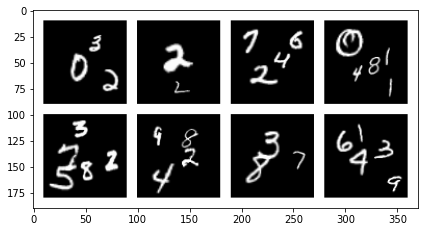

In [34]:
show_batch(imgs_in)

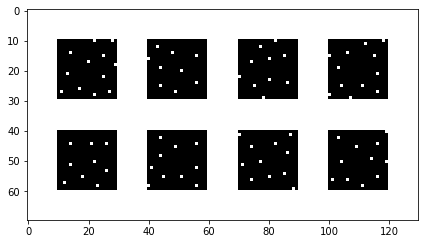

In [32]:
show_batch(out.inference.sample_c_map)

In [39]:
index = torch.arange(4).view(-1,1).expand(-1,4)
index

x = torch.zeros((400,4))
y= x.scatter(dim=0, index=index, src=torch.ones_like(x))

In [41]:
y.shape

torch.Size([400, 4])

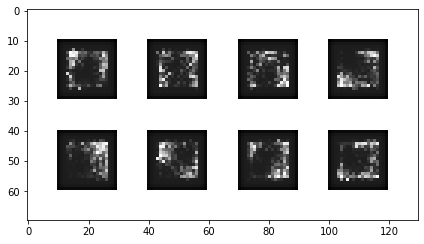

In [29]:
show_batch(out.inference.prob_map)

In [30]:
out.inference.kl_logit

tensor([-425.2641, -436.1841, -432.1406, -426.0144, -436.0650, -433.1842,
        -429.5867, -429.5433], grad_fn=<SubBackward0>)

In [ ]:
img_to_segment = train_loader.img[0, :, 1060:1360, 2100:2400]
plt.imshow(img_to_segment[0])

In [ ]:
ix = 1240-160
iy= 2140
print(ix)
img_to_segment = train_loader.img[0, :, ix:ix+2*(80), iy:iy+4*(80)]
plt.imshow(img_to_segment[0])

In [ ]:

img_to_segment = train_loader.img[0, :, 940:1240, 2140:2440]
plt.imshow(img_to_segment[0])

In [ ]:
Entropy(\pi)

In [ ]:
# params

In [ ]:
image_size = params['input_image']['size_raw_image']
b, c, w, h = 8, params['input_image']['ch_in'], image_size, image_size
imgs_in = torch.sigmoid(torch.randn(b,c,w, h))



In [ ]:
show_batch(imgs_in)

In [ ]:
#from MODULES.utilities_ml import SpecialDataSet
#
#train_loader = SpecialDataSet(img=imgs_in,
#                              store_in_cuda=False,
#                              shuffle=True,
#                              drop_last=True,
#                              batch_size=2)
#optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])
#epoch_restart = -1
#history_dict = {}
#min_test_loss = 99999999
#    
#for delta_epoch in range(1, 5):
#    epoch = delta_epoch+epoch_restart
#    with torch.autograd.set_detect_anomaly(True):
#        train_metrics = process_one_epoch(model=vae, 
#                                          dataloader=train_loader, 
#                                          optimizer=optimizer, 
#                                          verbose=True)
#        print(train_metrics.pretty_print(epoch))

In [ ]:
vae.inference_and_generator.similarity_kernel_dpp.get_l_w()

In [ ]:
print(generated._fields)
print(generated.inference._fields)
print(generated.inference.sample_c_map.shape)
show_batch(generated.inference.sample_c_map.float())

In [ ]:
#generated.inference.prob_map[0,0]

In [ ]:
show_batch(generated.inference.prob_map)

In [ ]:
from MODULES.utilities_visualization import plot_reconstruction_and_inference, plot_segmentation

plot_reconstruction_and_inference(generated, epoch=0, prefix="gen_")

In [ ]:
vae.prob_corr_factor = 0.0
output = vae.forward(imgs_in, draw_image=True, draw_boxes=True, verbose=False)

In [ ]:
print(torch.max(output.inference.prob_map))
show_batch(output.inference.prob_map)

In [ ]:
c_map_2 = (torch.rand_like(output.inference.prob_map) < output.inference.prob_map).float()
show_batch(c_map_2)

In [ ]:
show_batch(output.inference.sample_c_map)

In [ ]:
show_batch(output.inference.sample_c_map)

In [ ]:
print(output.inference.bb_few.bh[..., 0])
print(vae.inference_and_generator.size_min)
print(vae.inference_and_generator.size_max)

In [ ]:
plot_reconstruction_and_inference(output, epoch=0, prefix="rec_")

In [ ]:
vae